In [ ]:
import sqlite3
import csv

conn = sqlite3.connect("sqlite.db")
cursor = conn.cursor()

In [ ]:
# Create table
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS sales (
    Item_Fat_Content TEXT,
    Item_Identifier TEXT,
    Item_Type TEXT,
    Outlet_Establishment_Year INTEGER,
    Outlet_Identifier TEXT,
    Outlet_Location_Type TEXT,
    Outlet_Size TEXT,
    Outlet_Type TEXT,
    Item_Visibility REAL,
    Item_Weight REAL,
    Sales REAL,
    Rating REAL
)
"""
)


def to_float(val):
    return float(val) if val.strip() else None  # or 0.0 if you prefer


def to_int(val):
    return int(val) if val.strip() else None  # or 0


with open("./blinkit_grocery_data.csv", newline="", encoding="utf-8-sig") as csvfile:
    reader = csv.DictReader(csvfile)
    rows = [
        (
            row["Item Fat Content"],
            row["Item Identifier"],
            row["Item Type"],
            to_int(row["Outlet Establishment Year"]),
            row["Outlet Identifier"],
            row["Outlet Location Type"],
            row["Outlet Size"],
            row["Outlet Type"],
            to_float(row["Item Visibility"]),
            to_float(row["Item Weight"]),
            to_float(row["Sales"]),
            to_float(row["Rating"]),
        )
        for row in reader
    ]


cursor.executemany(
    """
INSERT INTO sales VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""",
    rows,
)

# Commit
conn.commit()

print("CSV data imported into SQLite database successfully.")

CSV data imported into SQLite database successfully.


In [ ]:
cursor.execute(
    "SELECT item_identifier, item_weight, count(item_weight) FROM sales GROUP BY item_identifier, item_weight LIMIT 10"
)
rows = cursor.fetchall()
for row in rows:
    print(row)

('DRA12', 11.6, 6)
('DRA24', None, 0)
('DRA24', 19.35, 5)
('DRA59', None, 0)
('DRA59', 8.27, 6)
('DRB01', None, 0)
('DRB01', 7.39, 2)
('DRB13', 6.115, 5)
('DRB24', 8.785, 4)
('DRB25', None, 0)


In [ ]:
# Update item_weight for NULL values
cursor.execute(
    """
UPDATE sales
SET item_weight = (
    SELECT DISTINCT a.item_weight
    FROM sales a
    WHERE a.item_identifier = sales.item_identifier
    AND a.item_weight IS NOT NULL
)
WHERE item_weight IS NULL
"""
)
conn.commit()

In [ ]:
cursor.execute(
    "UPDATE sales SET item_fat_content = 'Low Fat' WHERE item_fat_content = 'LF'"
)
cursor.execute(
    "UPDATE sales SET item_fat_content = 'Low Fat' WHERE item_fat_content = 'low fat'"
)
cursor.execute(
    "UPDATE sales SET item_fat_content = 'Regular' WHERE item_fat_content = 'reg'"
)
conn.commit()

In [ ]:
cursor.execute(
    """SELECT a.item_identifier, 
               a.item_fat_content, 
               a.item_type, 
               a.item_weight, 
               count(a.item_identifier) 
               FROM 
               (SELECT DISTINCT item_identifier, 
               item_fat_content, 
               item_type, 
               item_weight 
               FROM sales) a 
               GROUP BY a.item_identifier 
               HAVING count(a.item_identifier) > 1"""
)

rows = cursor.fetchall()
for row in rows:
    print(row)

In [ ]:
# create an item table with item_identifier, item_fat_content, item_type, item_weight
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS items (
    item_identifier TEXT PRIMARY KEY,
    item_fat_content TEXT,
    item_type TEXT,
    item_weight REAL
)
"""
)

# insert data into items table
cursor.execute(
    """
INSERT INTO items (item_identifier, item_fat_content, item_type, item_weight)
SELECT DISTINCT item_identifier, item_fat_content, item_type, item_weight FROM sales
"""
)
conn.commit()

In [ ]:
# create an outlet table with outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_size, outlet_type
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS outlets (
    outlet_identifier TEXT PRIMARY KEY,
    outlet_establishment_year INTEGER,
    outlet_location_type TEXT,
    outlet_type TEXT
)
"""
)

# insert data into outlets table
cursor.execute(
    """
INSERT INTO outlets (outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_type)
SELECT DISTINCT outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_type FROM sales
"""
)
conn.commit()

In [ ]:
# create a sales table with item_identifier, outlet_identifier, item_visibility, sales, rating
cursor.execute(
    """
CREATE TABLE sales_new AS
SELECT 
    item_identifier,
    outlet_identifier,
    outlet_size,
    item_visibility,
    sales,
    rating
FROM sales
"""
)

cursor.execute("DROP TABLE sales")

cursor.execute("ALTER TABLE sales_new RENAME TO sales")

conn.commit()

In [11]:
conn.close()

Dataset loaded successfully.

--- Initial Data Inspection ---

First 5 Rows (Snapshot similar to PBI data view):
  Item Fat Content Item Identifier              Item Type  \
0          Regular           FDX32  Fruits and Vegetables   
1          Low Fat           NCB42     Health and Hygiene   
2          Regular           FDR28           Frozen Foods   
3          Regular           FDL50                 Canned   
4          Low Fat           DRI25            Soft Drinks   

   Outlet Establishment Year Outlet Identifier Outlet Location Type  \
0                       2012            OUT049               Tier 1   
1                       2022            OUT018               Tier 3   
2                       2016            OUT046               Tier 1   
3                       2014            OUT013               Tier 3   
4                       2015            OUT045               Tier 2   

  Outlet Size        Outlet Type  Item Visibility  Item Weight     Sales  \
0      Medium  Su

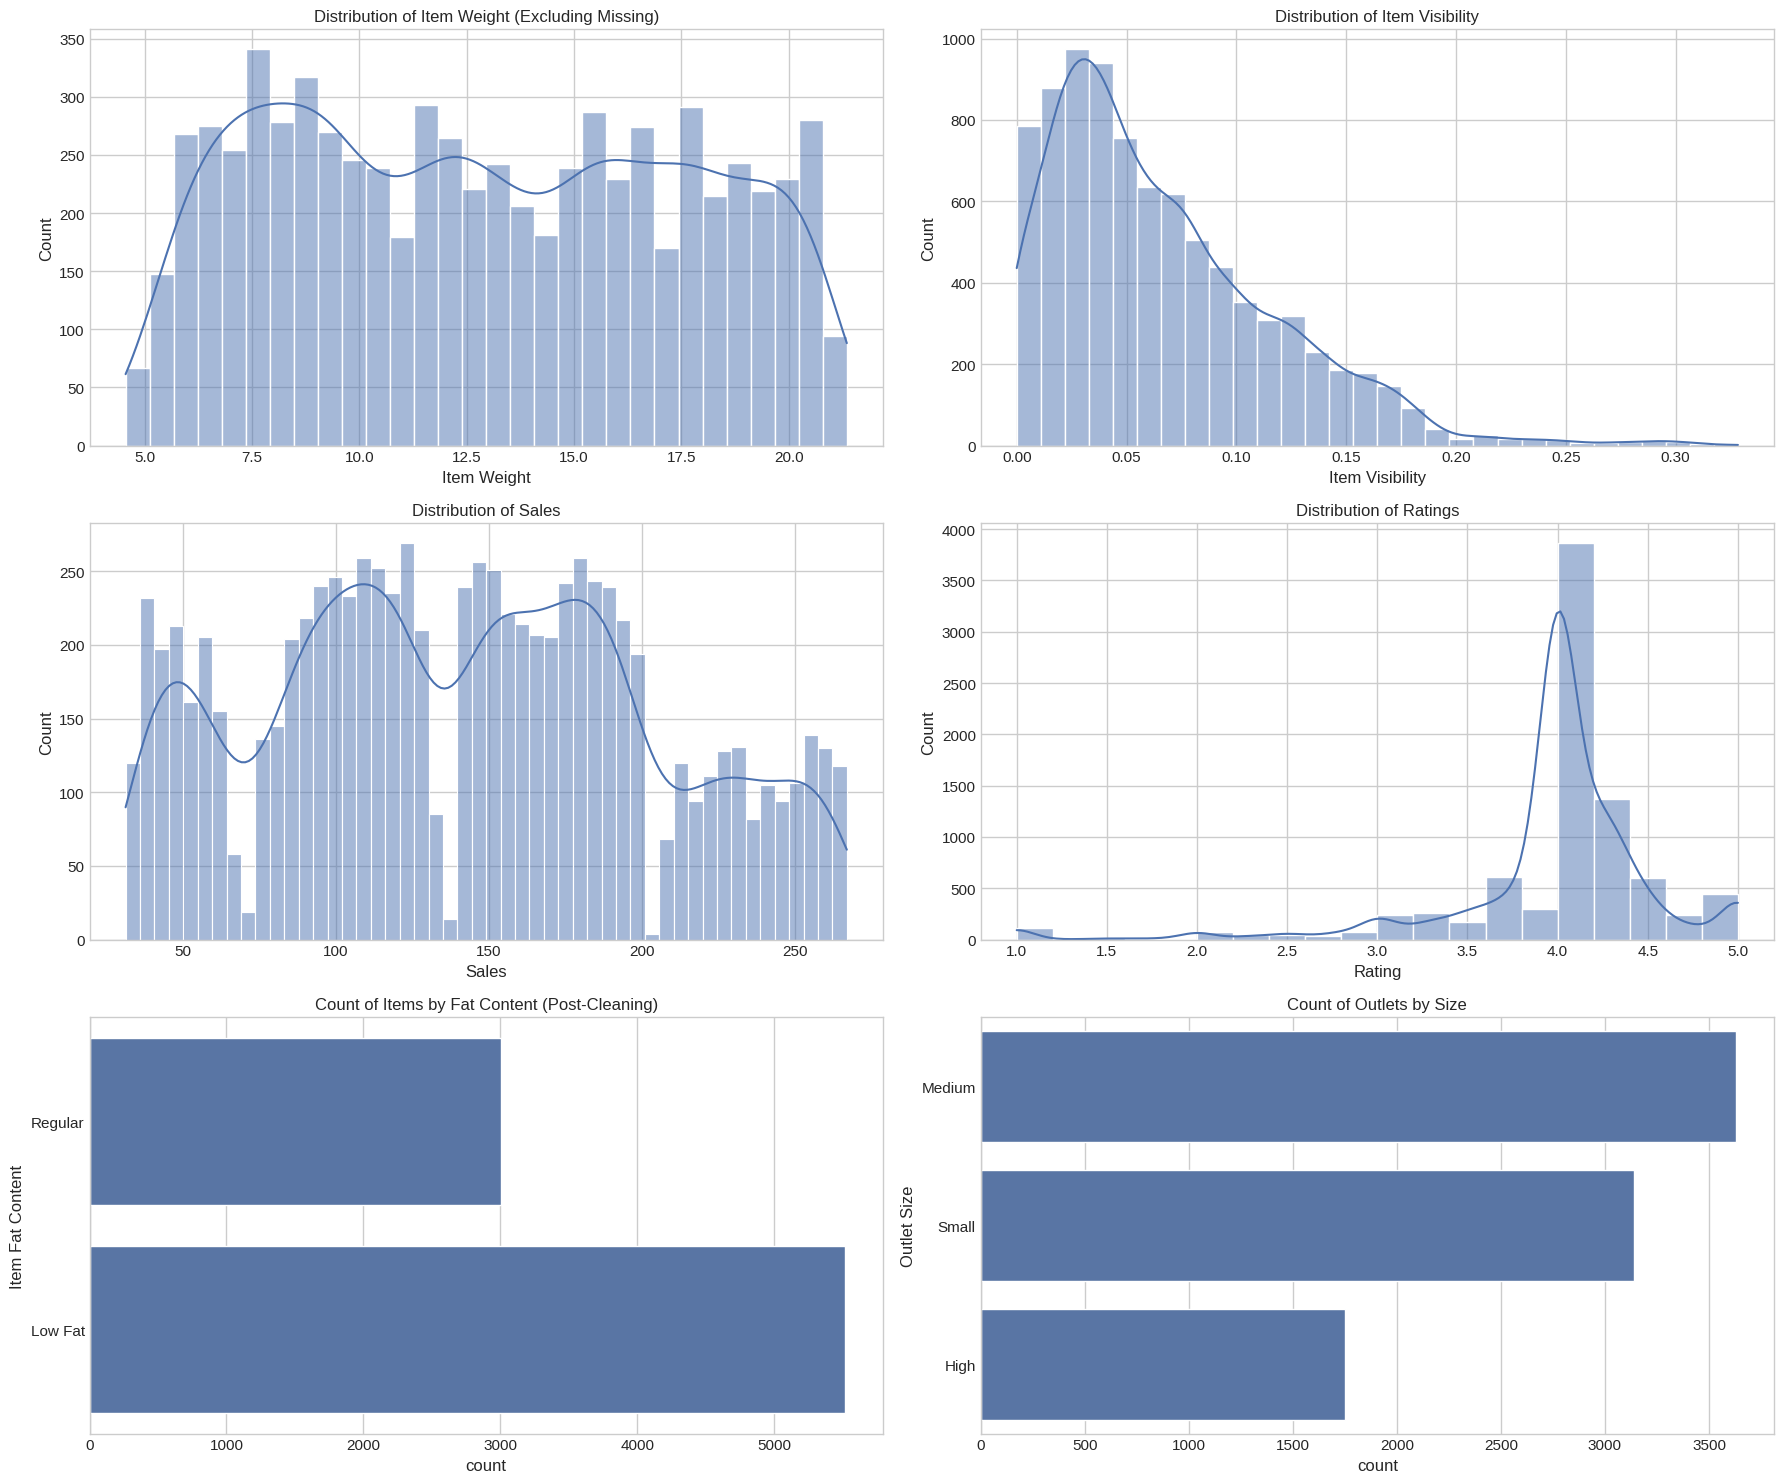

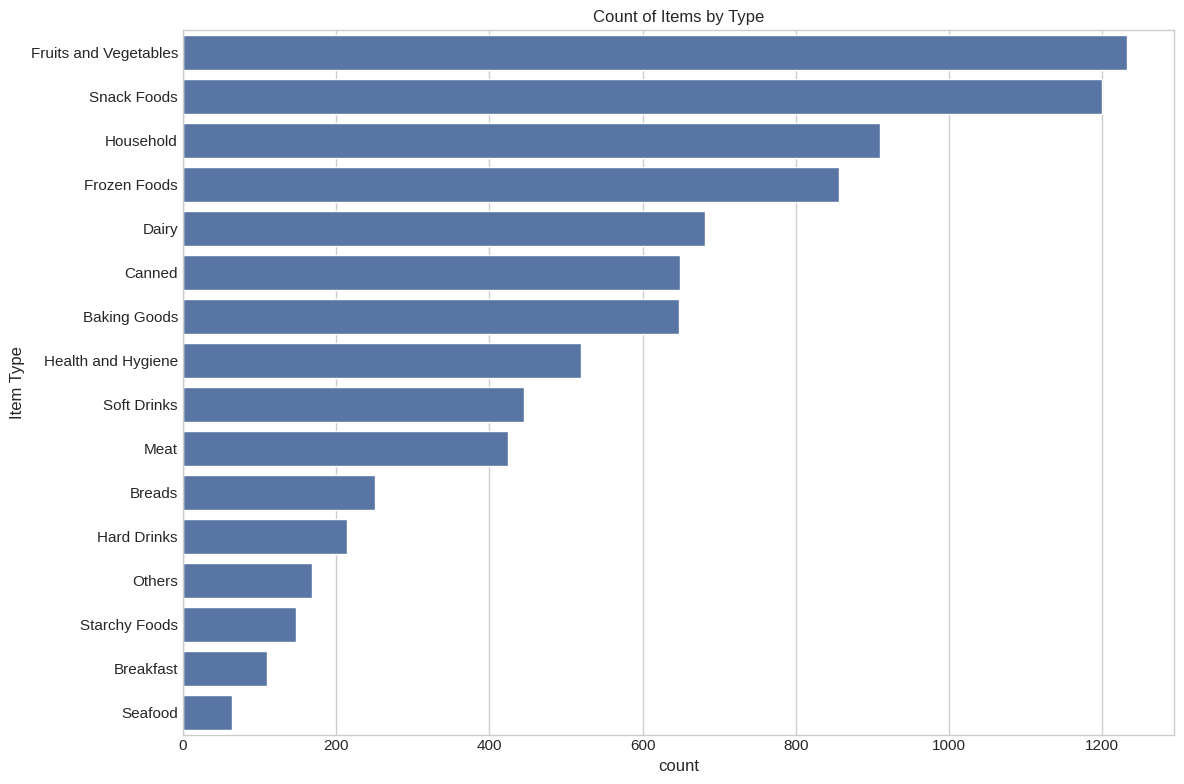

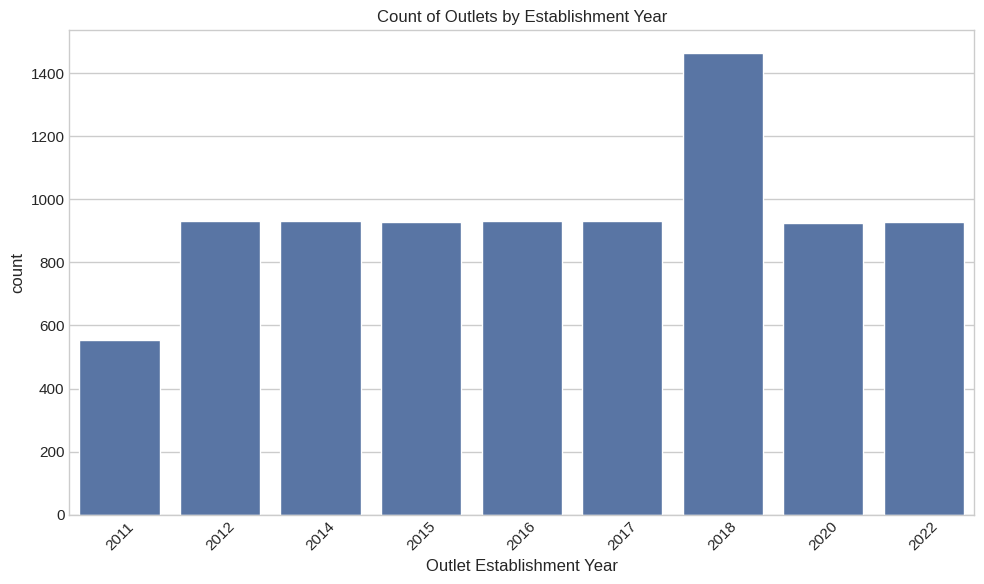

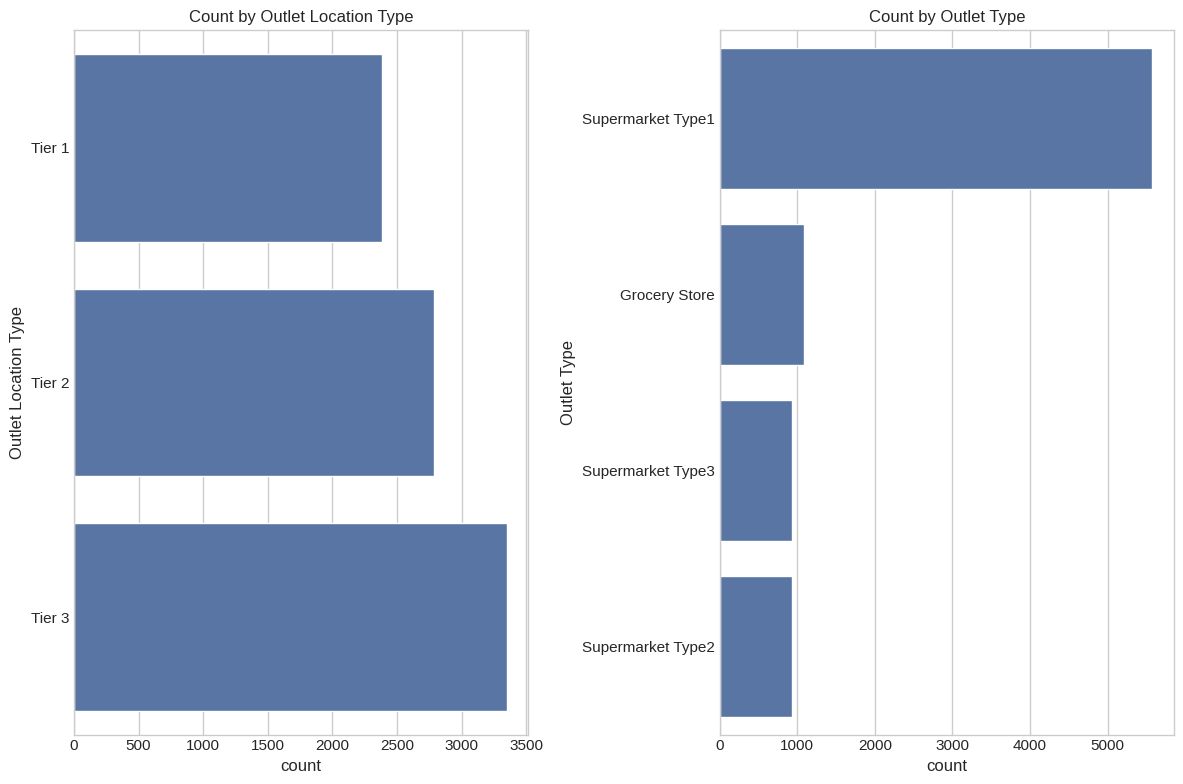


--- Bivariate Analysis ---


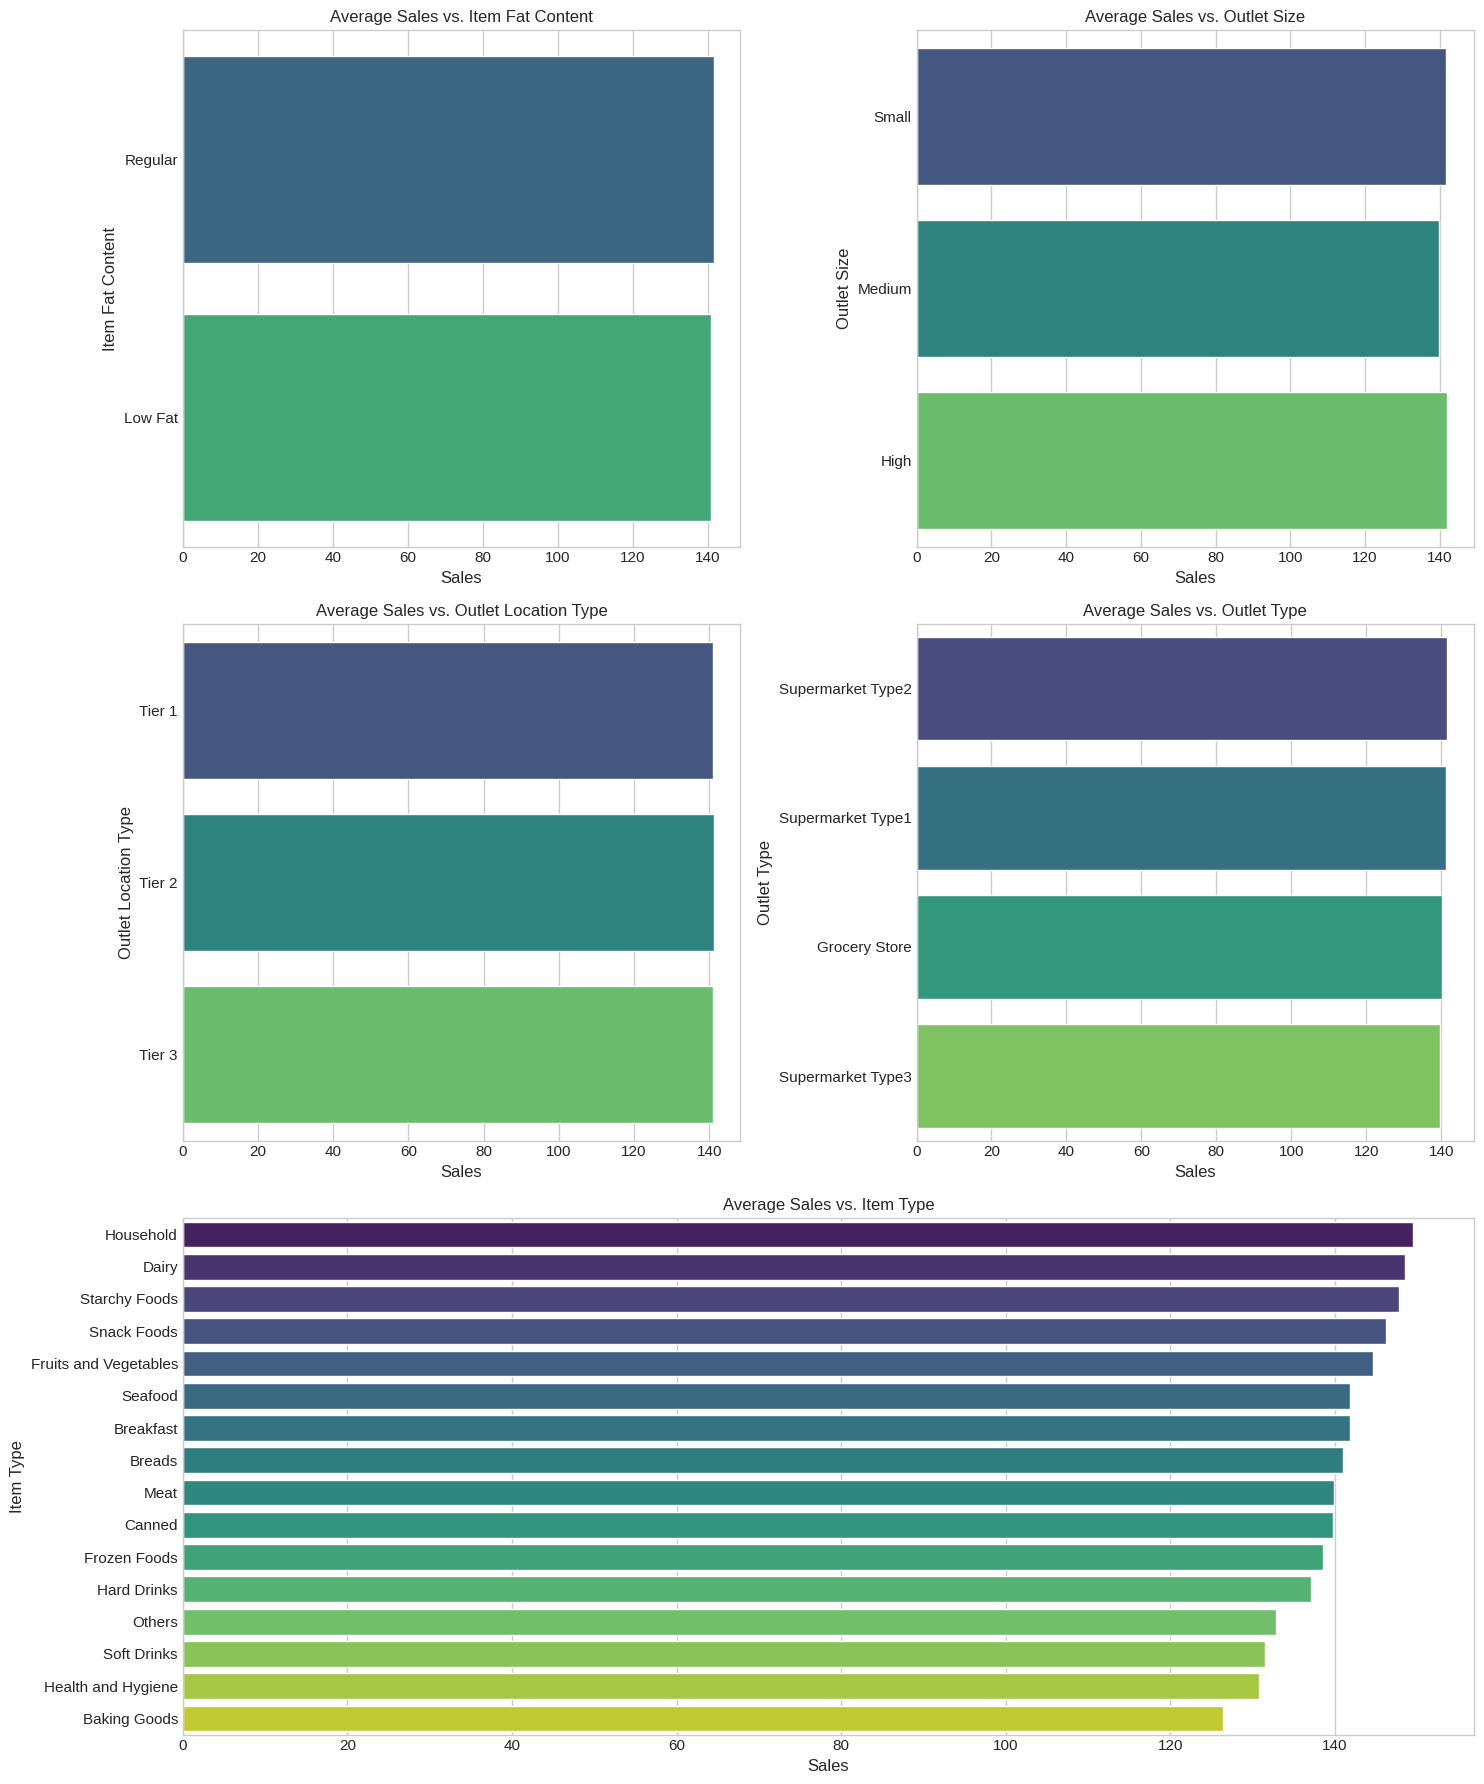

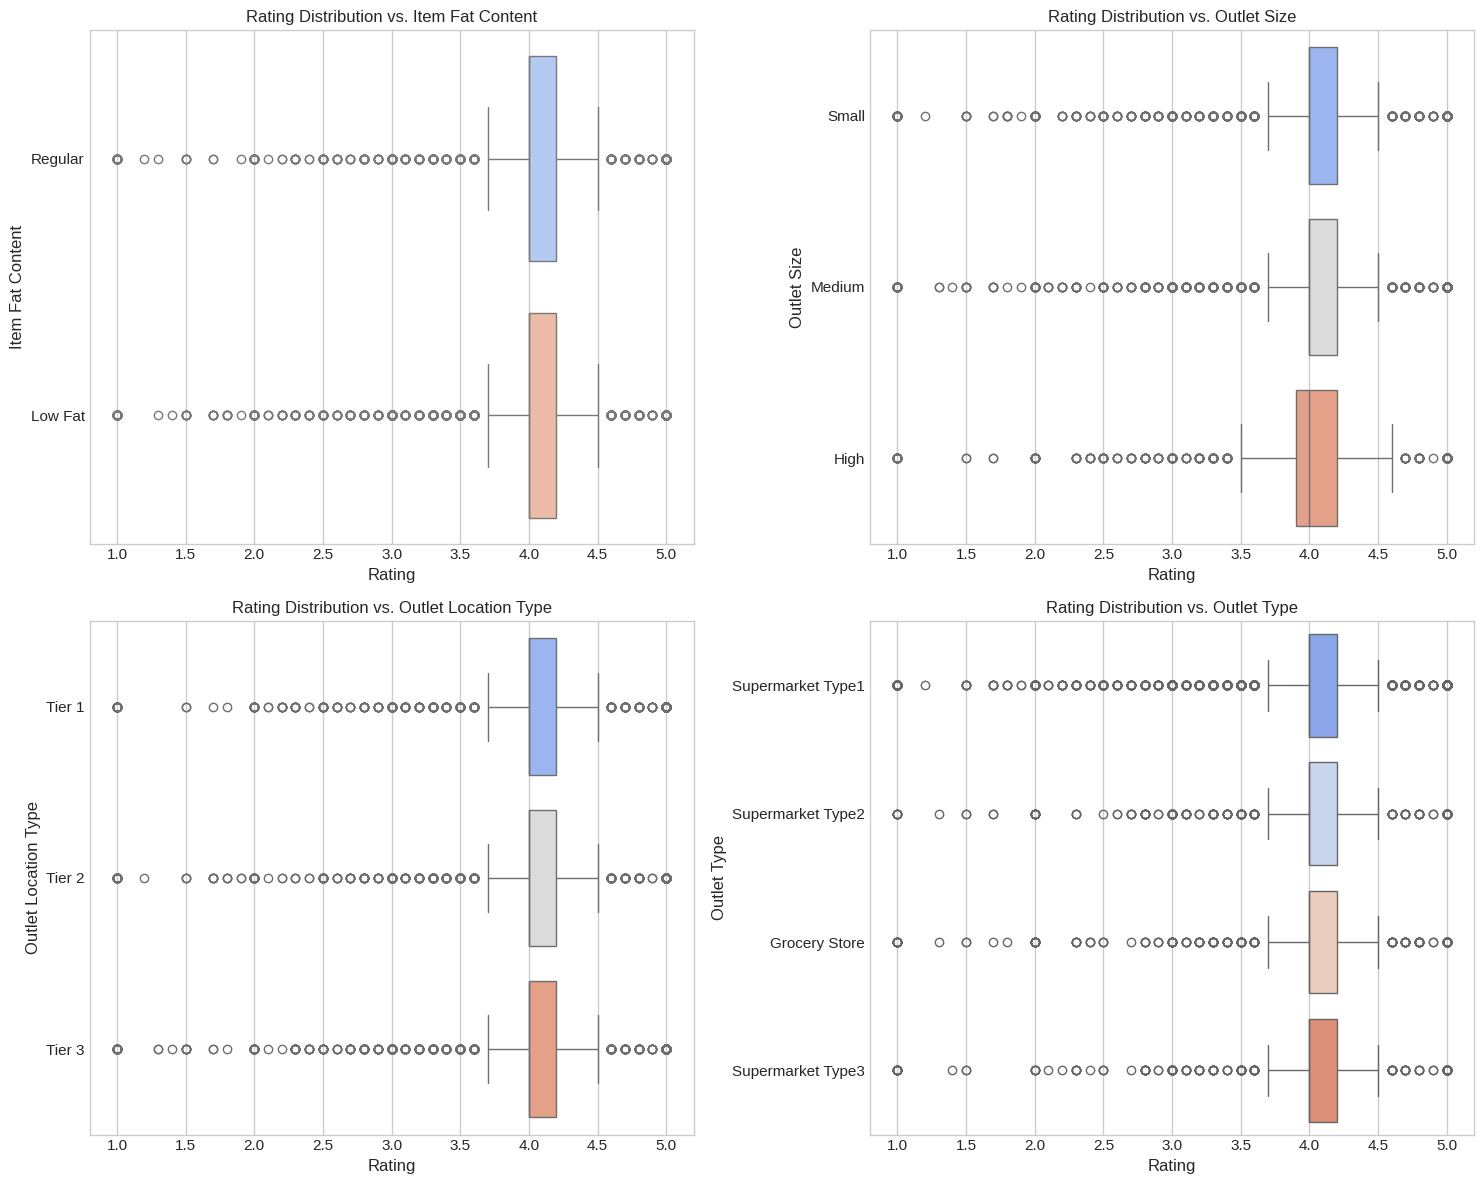

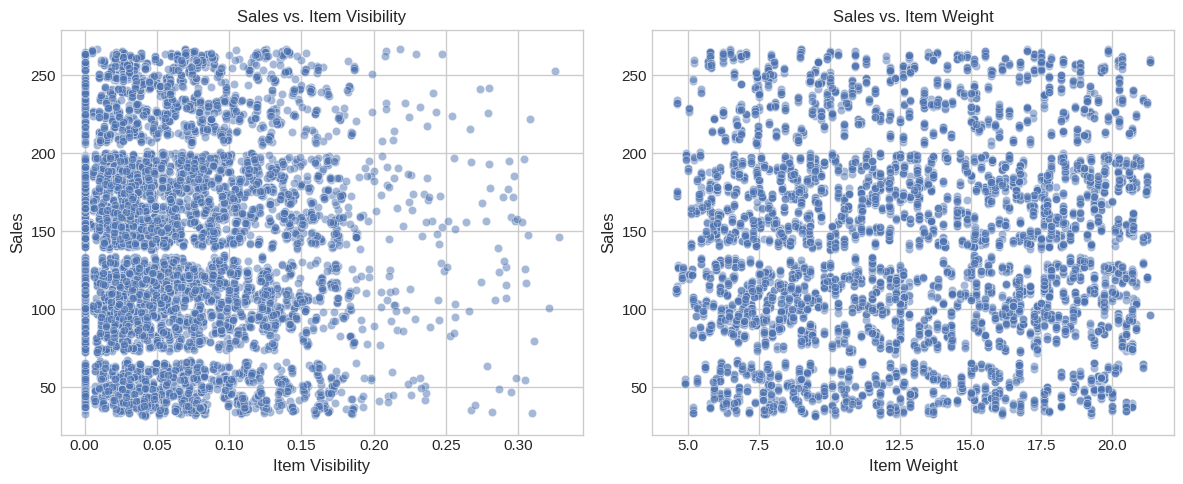

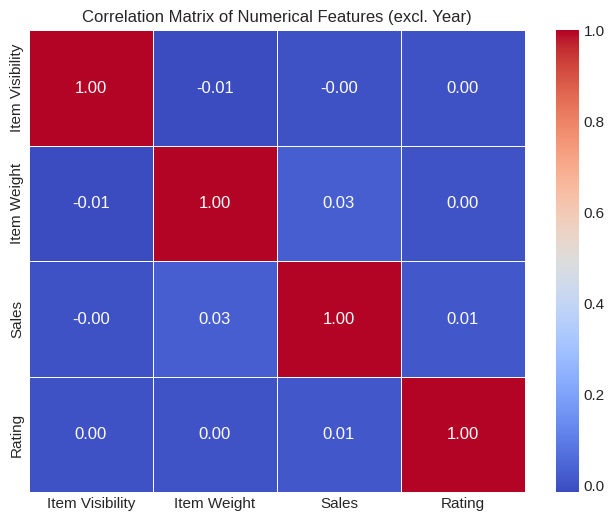


--- EDA Summary (Aligned with Power BI Project) ---
*   Data consists of 8523 observations and 12 features, matching the scope seen in Power BI.
*   Key features analyzed align with PBI visuals: item details (fat content, type, visibility), outlet details (establishment year, size, location, type), sales, and ratings.
*   Data Cleaning: Standardized 'Item Fat Content' mirroring Power Query steps. Acknowledged missing 'Item Weight' as observed in PBI's quality check.
*   Distribution Insights (Supporting PBI Visuals):
    - Sales is right-skewed, explaining PBI KPIs (Total $1.2M, Avg $141).
    - Item Visibility has many values near zero (seen in EDA, relevant to PBI matrix's average visibility).
    - Ratings are roughly normally distributed around the PBI average KPI of 3.9.
    - Categorical counts match PBI observations: 'Low Fat' prevalence (~65%), 'Medium' outlets most frequent (and highest total sales in PBI), 'Tier 3' locations most frequent (highest total sales in PBI), 'Super

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plot style
sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")  # Use a seaborn style

# --- 1. Load the Data ---
# Load data from the Excel file used in the Power BI project
# The transcript confirms the data source is an Excel file.
file_path = "blinkit_grocery_data_orignal.xlsx"  # <--- CHANGE THIS if your file name/path is different
try:
    # Reading the specific sheet if necessary, though PBI likely loaded the first/only sheet.
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()  # Exit if file not found

# --- 2. Initial Data Inspection ---
print("\n--- Initial Data Inspection ---")

print("\nFirst 5 Rows (Snapshot similar to PBI data view):")
print(df.head())

print("\nDataset Shape (Rows, Columns) - Confirms PBI observation:")
# Transcript mentions ~8500 rows and 12 columns.
print(df.shape)  # Should output something like (8523, 12)

print("\nColumn Names and Data Types (Reviewed in PBI Data View/Power Query):")
df.info()  # Shows columns like Item_Fat_Content, Sales, Rating, Outlet_Establishment_Year etc.

print("\nSummary Statistics (Numerical Columns) - Basis for PBI KPIs:")
# Provides mean, min, max etc. which inform the calculated KPIs like Average Sales, Average Rating.
print(df.describe().round(2))

print(
    "\nSummary Statistics (Categorical Columns) - Shows unique counts/top categories:"
)
# Gives an overview of categorical distributions seen in PBI slicers/charts.
print(df.describe(include="object"))

# Check for potential leading/trailing spaces in column names (Good practice, though not explicit in PBI video)
df.columns = df.columns.str.strip()
print("\nColumn Names (stripped):", df.columns.tolist())

# --- 3. Data Cleaning ---
print("\n--- Data Cleaning ---")

# Check for missing values (Reviewed in PBI Power Query using 'Column Quality')
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Address Missing Values (Based on Transcript Insights from Power Query)
# Item Weight: Transcript notes PBI identified missing values (~16% empty) but deemed them acceptable for the specific dashboard scope, so no imputation shown.
print(
    f"\n'Item Weight' has {df['Item Weight'].isnull().sum()} missing values (acknowledged in PBI)."
)
# Outlet Size: Transcript doesn't explicitly state missing values were found *and* imputed for Outlet Size in *this* dataset during PBI steps, though it's a common scenario. We check here.
if df["Outlet Size"].isnull().any():
    print(f"\nFound {df['Outlet Size'].isnull().sum()} missing values in Outlet Size.")
    # In a real project/different PBI workflow, imputation (e.g., with mode) might occur here.
    # df['Outlet Size'].fillna(df['Outlet Size'].mode()[0], inplace=True)
    # print("Missing Outlet Size values imputed with mode for potential modeling (not shown in PBI video).")
else:
    print(
        "\nNo missing values found in Outlet Size (as per PBI video's final data state)."
    )


# Standardize 'Item Fat Content' (Mirroring Power BI Power Query 'Replace Values' steps)
print("\nStandardizing 'Item Fat Content'...")
print("Original unique values:", df["Item Fat Content"].unique())
# Applying the exact replacements shown in the PBI video (LF -> Low Fat, low fat -> Low Fat, reg -> Regular)
df["Item Fat Content"] = df["Item Fat Content"].replace(
    {
        "LF": "Low Fat",
        "low fat": "Low Fat",  # Handles case sensitivity issue identified implicitly in PBI
        "reg": "Regular",
    }
)
# Renaming the columns to match the video's final state (optional, but good practice)
df.rename(
    columns={
        "Item_Identifier": "Item Identifier",
        "Item_Weight": "Item Weight",
        "Item_Fat_Content": "Item Fat Content",
        "Item_Visibility": "Item Visibility",
        "Item_Type": "Item Type",
        "Outlet_Identifier": "Outlet Identifier",
        "Outlet_Establishment_Year": "Outlet Establishment Year",
        "Outlet_Size": "Outlet Size",
        "Outlet_Location_Type": "Outlet Location Type",
        "Outlet_Type": "Outlet Type",
        # Assuming 'Sales' and 'Rating' are already correctly named
    },
    inplace=True,
)

print(
    "Cleaned unique values:", df["Item Fat Content"].unique()
)  # Should now be ['Low Fat', 'Regular']
print("'Item Fat Content' standardized, mirroring Power Query cleaning.")


# --- 4. Univariate Analysis (Analyzing Single Variables) ---
print("\n--- Univariate Analysis ---")

# Set figure size for plots
plt.figure(figsize=(18, 15))

# Numerical Distributions
# Purpose: To understand the distribution of key numerical variables identified in PBI.
# EDA Insight (Item Weight): Confirms the presence of data points and missing values (not plotted). Distribution might be somewhat multimodal.
# Impact: Reinforces the PBI decision that weight wasn't a primary focus for *this* dashboard due to missing data, though it could be relevant elsewhere.
plt.subplot(3, 2, 1)
sns.histplot(df["Item Weight"].dropna(), kde=True, bins=30)
plt.title("Distribution of Item Weight (Excluding Missing)")

# Purpose: To visualize the spread of item visibility values.
# EDA Insight (Item Visibility): Histogram confirms the PBI observation that many items have visibility near zero, with a right skew.
# Impact: Highlights a data quality concern or specific business scenario (like backroom stock) also relevant in PBI context. Average visibility was used in the PBI matrix.
plt.subplot(3, 2, 2)
sns.histplot(df["Item Visibility"], kde=True, bins=30)
plt.title("Distribution of Item Visibility")

# Purpose: To understand the distribution of the primary target variable, 'Sales'.
# EDA Insight (Sales): Shows a strong right skew. Most sales cluster at lower values, but a long tail pulls the average ($141) higher than the median, contributing to the total sales ($1.2M) seen in PBI KPIs.
# Impact: Explains the relationship between average and total sales KPIs in PBI. Skewness is important if building predictive models beyond the PBI dashboard.
plt.subplot(3, 2, 3)
sns.histplot(df["Sales"], kde=True, bins=50)
plt.title("Distribution of Sales")

# Purpose: To see how customer ratings are distributed, informing the PBI average rating KPI.
# EDA Insight (Rating): Shows a roughly normal distribution centered near the PBI KPI average of 3.9. The transcript noted this average might be considered 'not good'.
# Impact: Provides context for the PBI average rating KPI, showing the spread around the average.
plt.subplot(3, 2, 4)
sns.histplot(df["Rating"].dropna(), kde=True, bins=20)
plt.title("Distribution of Ratings")

# Categorical Distributions
# Purpose: To see the frequency of each fat content category after cleaning, matching PBI donut chart proportions.
# EDA Insight (Item Fat Content): Confirms 'Low Fat' items are more frequent (~65%) than 'Regular' (~35%), aligning with the PBI donut chart visualization.
# Impact: Validates the cleaning and provides the underlying count data for the PBI fat content visual.
plt.subplot(3, 2, 5)
sns.countplot(y=df["Item Fat Content"])
plt.title("Count of Items by Fat Content (Post-Cleaning)")

# Purpose: To visualize the frequency of different outlet sizes, relevant to PBI filters and charts.
# EDA Insight (Outlet Size): Shows the counts for 'Small', 'Medium', 'High'. 'Medium' is often the most frequent, aligning with it having the highest total sales in the PBI donut chart. Checks for 'Missing' if imputation wasn't strictly performed earlier.
# Impact: Provides context for the PBI 'Outlet Size' slicer and donut chart.
plt.subplot(3, 2, 6)
sns.countplot(y=df["Outlet Size"].fillna("Missing"))
plt.title("Count of Outlets by Size")


plt.tight_layout()
plt.show()


# Plotting distributions for high-cardinality categoricals separately
# Purpose: To understand the frequency distribution across numerous item types, as shown in the PBI bar chart.
# EDA Insight (Item Type): Identifies 'Fruits and Vegetables' and 'Snack Foods' as the most frequent item types, aligning with the PBI bar chart showing these have the highest *number* of items sold (though not necessarily highest average sales).
# Impact: Provides context for the PBI 'Item Type' slicer and bar chart. Shows product mix diversity.
plt.figure(figsize=(12, 8))
sns.countplot(y=df["Item Type"], order=df["Item Type"].value_counts().index)
plt.title("Count of Items by Type")
plt.tight_layout()
plt.show()

# Purpose: To see the distribution of outlets by establishment year, corresponding to the PBI line chart's x-axis.
# EDA Insight (Outlet Establishment Year): Shows the number of outlets opened each year present in the data. Allows comparison with the PBI line chart which showed sales trends over these years (e.g., 2018 peak).
# Impact: Provides context for the PBI line chart showing sales performance based on outlet age/establishment year.
plt.figure(figsize=(10, 6))
sns.countplot(
    x=df["Outlet Establishment Year"],
    order=sorted(df["Outlet Establishment Year"].unique()),
)
plt.title("Count of Outlets by Establishment Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Purpose: To visualize outlet counts by location tier and type, relevant to PBI filters and charts.
# EDA Insight (Location & Type): Shows 'Tier 3' locations and 'Supermarket Type1' outlets are the most frequent, aligning with their significance in the PBI analysis (e.g., Tier 3 highest sales, prevalence of Supermarket Type1).
# Impact: Provides context for the PBI slicers and charts related to outlet location and type, showing the composition of the store network.
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.countplot(
    y=df["Outlet Location Type"], order=["Tier 1", "Tier 2", "Tier 3"]
)  # Order logically
plt.title("Count by Outlet Location Type")

plt.subplot(1, 2, 2)
sns.countplot(y=df["Outlet Type"], order=df["Outlet Type"].value_counts().index)
plt.title("Count by Outlet Type")

plt.tight_layout()
plt.show()

# --- 5. Bivariate Analysis (Analyzing Relationships Between Two Variables) ---
print("\n--- Bivariate Analysis ---")

# Sales vs. Categorical Variables (Using Barplots to show Average Sales per category)
# Purpose: To investigate how average sales differ across categories, complementing PBI visuals that often show totals or use parameters.
# EDA Insight: Reveals average sales differences. E.g., while 'Low Fat' is more frequent (PBI Donut), 'Regular' might have comparable or slightly different *average* sales. 'Medium' outlets had highest total sales (PBI Donut), this plot checks their *average* sales rank. Tier 3 had highest total sales (PBI Funnel), this checks its *average*. Supermarket Type 1 is frequent, this checks its *average* sales vs other types. Certain 'Item Types' (like Household) might have high *average* sales even if not the most *frequent* (PBI Bar Chart).
# Impact: Provides the 'average sales' perspective often calculated implicitly or shown via tooltips in PBI, complementing the total sales or count views. Identifies categories driving high average transaction value.
plt.figure(figsize=(15, 18))

# Purpose: Compare average sales between 'Low Fat' and 'Regular'.
# EDA Insight: Likely shows small difference in average sales, confirming fat content isn't a major sales value driver, as seen in PBI.
# Impact: Supports PBI findings on fat content's role.
plt.subplot(3, 2, 1)
sns.barplot(data=df, y="Item Fat Content", x="Sales", palette="viridis", ci=None)
plt.title("Average Sales vs. Item Fat Content")

# Purpose: Compare average sales across 'Outlet Size'.
# EDA Insight: Shows average sales rank (e.g., Medium might also have high average, or maybe High/Small). Complements PBI donut showing total sales.
# Impact: Adds nuance to the PBI Outlet Size analysis (total vs. average).
plt.subplot(3, 2, 2)
sns.barplot(
    data=df,
    y="Outlet Size",
    x="Sales",
    order=["Small", "Medium", "High"],  # Logical order
    palette="viridis",
    ci=None,
)
plt.title("Average Sales vs. Outlet Size")

# Purpose: Compare average sales across 'Outlet Location Type'.
# EDA Insight: Shows average sales for Tier 1, 2, 3. Complements PBI funnel showing total sales (Tier 3 highest total).
# Impact: Adds nuance to the PBI Location analysis (total vs. average).
plt.subplot(3, 2, 3)
sns.barplot(
    data=df,
    y="Outlet Location Type",
    x="Sales",
    order=["Tier 1", "Tier 2", "Tier 3"],  # Logical order
    palette="viridis",
    ci=None,
)
plt.title("Average Sales vs. Outlet Location Type")

# Purpose: Compare average sales across 'Outlet Type'.
# EDA Insight: Shows potentially large differences in average sales (e.g., Supermarket types vs. Grocery Store), aligning with PBI matrix insights.
# Impact: Highlights 'Outlet Type' as a strong factor influencing average sales value, supporting PBI findings.
plt.subplot(3, 2, 4)
sns.barplot(
    data=df,
    y="Outlet Type",
    x="Sales",
    palette="viridis",
    ci=None,
    order=df.groupby("Outlet Type")["Sales"].mean().sort_values(ascending=False).index,
)  # Order by avg sales
plt.title("Average Sales vs. Outlet Type")

# Purpose: Compare average sales across 'Item Type'.
# EDA Insight: Identifies item types with highest/lowest average sales (e.g., Household high avg). Contrasts with PBI bar chart showing most *frequent* types (Fruits/Veggies, Snacks).
# Impact: Crucial insight complementing PBI - frequency vs. average value.
plt.subplot(3, 1, 3)  # Span across bottom
sns.barplot(
    data=df,
    y="Item Type",
    x="Sales",
    palette="viridis",
    ci=None,
    order=df.groupby("Item Type")["Sales"]
    .mean()
    .sort_values(ascending=False)
    .index,  # Order by avg sales
)
plt.title("Average Sales vs. Item Type")


plt.tight_layout()
plt.show()


# Rating vs. Categorical Variables (Using Boxplots to show Rating Distribution)
# Purpose: To see if rating *distributions* vary significantly across categories, unlike PBI which focused on the overall average rating KPI.
# EDA Insight: Boxplots generally show that the *median* and *spread* (IQR) of ratings are quite similar across different fat contents, outlet sizes, locations, and types. This supports the PBI observation that the overall average rating (3.9) is representative, with no single segment having drastically different satisfaction levels.
# Impact: Suggests these categories aren't strong drivers of *rating variation*. Provides context that the 'average' rating KPI in PBI doesn't hide vastly different experiences in specific segments.
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x="Rating", y="Item Fat Content", palette="coolwarm")
plt.title("Rating Distribution vs. Item Fat Content")

plt.subplot(2, 2, 2)
sns.boxplot(
    data=df,
    x="Rating",
    y="Outlet Size",
    order=["Small", "Medium", "High"],
    palette="coolwarm",
)
plt.title("Rating Distribution vs. Outlet Size")

plt.subplot(2, 2, 3)
sns.boxplot(
    data=df,
    x="Rating",
    y="Outlet Location Type",
    order=["Tier 1", "Tier 2", "Tier 3"],
    palette="coolwarm",
)
plt.title("Rating Distribution vs. Outlet Location Type")

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x="Rating", y="Outlet Type", palette="coolwarm")
plt.title("Rating Distribution vs. Outlet Type")

plt.tight_layout()
plt.show()


# Numerical vs. Numerical Relationships
# Purpose: To visualize relationships between numerical predictors and Sales, which weren't the primary focus of the PBI charts shown.
# EDA Insight: Scatter plots confirm observations from correlation matrix.
# Impact: Provides deeper insight into relationships that PBI summarized differently (e.g., using averages or totals rather than direct scatter plots).
plt.figure(figsize=(12, 5))

# Purpose: Check linear relationship between Item Visibility and Sales.
# EDA Insight: Shows a weak, potentially non-linear relationship. Confirms the PBI observation of items with zero visibility having sales, making the direct relationship complex.
# Impact: Explains why PBI might have used average visibility in the matrix rather than showing a direct scatter. Highlights data peculiarity.
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="Item Visibility", y="Sales", alpha=0.5)
plt.title("Sales vs. Item Visibility")

# Purpose: Check linear relationship between Item Weight and Sales.
# EDA Insight: Shows no strong linear trend, consistent with PBI not emphasizing weight as a direct sales driver in its visuals (and presence of missing data).
# Impact: Supports the PBI approach; weight might be less important for *this specific* analysis.
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="Item Weight", y="Sales", alpha=0.5)
plt.title("Sales vs. Item Weight")

plt.tight_layout()
plt.show()


# Correlation Heatmap for numerical features
# Purpose: To quantify linear correlations between numerical variables, including Sales, Rating, Visibility, Weight.
# EDA Insight: Confirms the weak linear correlations seen in scatter plots (Sales vs. Visibility, Sales vs. Weight). Rating also shows weak linear correlation with Sales and other features.
# Impact: Provides a numerical summary complementing the visual EDA and PBI's focus on categorical drivers. Reinforces that linear relationships between these specific numerical variables are not strong drivers in this dataset.
plt.figure(figsize=(8, 6))
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=np.number).drop(
    columns=["Outlet Establishment Year"]
)  # Year is numerical but treated as categorical/time
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features (excl. Year)")
plt.show()


# --- 6. Summary of EDA Findings ---
print("\n--- EDA Summary (Aligned with Power BI Project) ---")
print(
    f"*   Data consists of {df.shape[0]} observations and {df.shape[1]} features, matching the scope seen in Power BI."
)
print(
    "*   Key features analyzed align with PBI visuals: item details (fat content, type, visibility), outlet details (establishment year, size, location, type), sales, and ratings."
)
print(
    "*   Data Cleaning: Standardized 'Item Fat Content' mirroring Power Query steps. Acknowledged missing 'Item Weight' as observed in PBI's quality check."
)
print("*   Distribution Insights (Supporting PBI Visuals):")
print("    - Sales is right-skewed, explaining PBI KPIs (Total $1.2M, Avg $141).")
print(
    "    - Item Visibility has many values near zero (seen in EDA, relevant to PBI matrix's average visibility)."
)
print(
    "    - Ratings are roughly normally distributed around the PBI average KPI of 3.9."
)
print(
    "    - Categorical counts match PBI observations: 'Low Fat' prevalence (~65%), 'Medium' outlets most frequent (and highest total sales in PBI), 'Tier 3' locations most frequent (highest total sales in PBI), 'Supermarket Type1' most common outlet type."
)
print(
    "    - 'Fruits and Vegetables' and 'Snack Foods' are the most frequently purchased Item Types (aligns with PBI count view)."
)
print("*   Relationship Insights (Explaining PBI Dashboard Findings):")
print(
    "    - Average sales vary significantly by factors highlighted in PBI: Item Type (Household high avg), Outlet Type (Supermarkets high avg), Outlet Size (Medium high avg), and Location Type (Tier 3 high avg)."
)
print(
    "    - Rating distributions are relatively consistent across categories (EDA boxplots), supporting PBI's focus on the overall average rating."
)
print(
    "    - Item Visibility and Weight show weak/complex linear relationships with Sales (EDA scatter/heatmap), explaining PBI's focus on other drivers."
)
print(
    "\nEDA complete. Python analysis confirms and provides underlying detail for the key patterns, distributions, and relationships visualized in the Power BI dashboard."
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Load Data ---
file_path = "blinkit_grocery_data_orignal.xlsx"  # <--- Make sure this path is correct
try:
    # When reading, pandas handles spaces in column names automatically
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
    # Strip any leading/trailing whitespace from column names just in case
    df.columns = df.columns.str.strip()
    print("Original column names:", df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()

# Rename 'Item Outlet Sales' for clarity if it exists (based on transcript)
if "Item Outlet Sales" in df.columns:
    df.rename(columns={"Item Outlet Sales": "Sales"}, inplace=True)
    print("Renamed 'Item Outlet Sales' to 'Sales'")

# Verify the target variable 'Sales' exists
if "Sales" not in df.columns:
    print("Error: Target column 'Sales' not found in the dataset.")
    exit()

# --- 2. Basic Cleaning & Feature Engineering ---
print("\n--- Cleaning Data ---")

# Standardize 'Item Fat Content'
print("Original 'Item Fat Content' values:", df["Item Fat Content"].unique())
df["Item Fat Content"] = df["Item Fat Content"].replace(
    {"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"}
)
print("Cleaned 'Item Fat Content' values:", df["Item Fat Content"].unique())

# Feature Engineering: Extract Outlet Age
current_year = pd.Timestamp.now().year
if "Outlet Establishment Year" in df.columns:
    df["Outlet Age"] = current_year - df["Outlet Establishment Year"]
    print("'Outlet Age' feature created.")
else:
    print("Warning: 'Outlet Establishment Year' not found, cannot create 'Outlet Age'.")


# --- 3. Feature Selection ---
# Drop identifiers and the original year column
# 'Item Identifier' and 'Outlet Identifier' usually don't help predict sales directly
# and have too many unique values (high cardinality) for simple encoding.
features_to_drop = ["Item Identifier", "Outlet Identifier"]
# Only drop Outlet Establishment Year if Outlet Age was created
if "Outlet Age" in df.columns:
    features_to_drop.append("Outlet Establishment Year")

# Check which columns actually exist before dropping
existing_cols_to_drop = [col for col in features_to_drop if col in df.columns]
df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"Dropped columns: {existing_cols_to_drop}")

# Define target and features
TARGET = "Sales"
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

print(f"\nPredicting '{TARGET}' using features: {FEATURES}")

# --- 4. Preprocessing ---
print("\n--- Setting up Preprocessing ---")

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Check if 'Outlet Size' is categorical and handle its order if needed
if "Outlet Size" in categorical_features:
    print("'Outlet Size' identified as categorical.")
    # Note: If treating as ordinal, you might use OrdinalEncoder separately
    # For simplicity here, we'll use OneHotEncoder which works for nominal/ordinal.

print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

# Create preprocessing pipelines for numerical and categorical features

# Numerical Pipeline:
# 1. Impute missing values (e.g., 'Item Weight', 'Rating') with the median
# 2. Scale features to have zero mean and unit variance
numerical_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Categorical Pipeline:
# 1. Impute missing values (e.g., 'Outlet Size') with a constant value like 'Missing' or the mode
# 2. One-Hot Encode categorical variables
categorical_pipeline = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),  # Or strategy='constant', fill_value='Missing'
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # handle_unknown ignores categories only seen in test data
    ]
)

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="passthrough",  # Keep any columns not specified (shouldn't be any here)
)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(
    f"\nData split into Train ({X_train.shape[0]} samples) and Test ({X_test.shape[0]} samples)"
)

# --- 6. Model Training ---
# We'll try two models: Linear Regression and RandomForestRegressor

# --- Model 1: Linear Regression ---
print("\n--- Training Linear Regression ---")
lr_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

lr_pipeline.fit(X_train, y_train)
print("Linear Regression training complete.")

# --- Model 2: Random Forest Regressor ---
print("\n--- Training Random Forest Regressor ---")
# For Random Forest, scaling is less critical, but the pipeline structure is convenient
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # n_estimators=100 is a common default, n_jobs=-1 uses all available CPU cores
        (
            "regressor",
            RandomForestRegressor(
                n_estimators=100,
                random_state=42,
                n_jobs=-1,
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=5,
            ),
        ),  # Added some hyperparameters
    ]
)

rf_pipeline.fit(X_train, y_train)
print("Random Forest training complete.")


# --- 7. Evaluation ---
print("\n--- Model Evaluation ---")

models = {"Linear Regression": lr_pipeline, "Random Forest": rf_pipeline}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"  R-squared (R2): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- Summary ---
print("\n--- Evaluation Summary ---")
results_df = pd.DataFrame(results).T  # Transpose for better viewing
print(results_df.round(4))

best_r2_model = results_df["R2"].idxmax()
print(f"\nModel with the best R-squared score on the test set: {best_r2_model}")

lr_model_filename = "linear_regression_sales_model.joblib"
rf_model_filename = "random_forest_sales_model.joblib"

# Save the Linear Regression pipeline (preprocessor + model)
try:
    joblib.dump(lr_pipeline, lr_model_filename)
    print(
        f"Linear Regression model pipeline saved successfully to '{lr_model_filename}'"
    )
except Exception as e:
    print(f"Error saving Linear Regression model: {e}")

# Save the Random Forest pipeline (preprocessor + model)
try:
    joblib.dump(rf_pipeline, rf_model_filename)
    print(f"Random Forest model pipeline saved successfully to '{rf_model_filename}'")
except Exception as e:
    print(f"Error saving Random Forest model: {e}")

Dataset loaded successfully.
Original column names: ['Item Fat Content', 'Item Identifier', 'Item Type', 'Outlet Establishment Year', 'Outlet Identifier', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Sales', 'Rating']

--- Cleaning Data ---
Original 'Item Fat Content' values: ['Regular' 'Low Fat' 'low fat' 'LF' 'reg']
Cleaned 'Item Fat Content' values: ['Regular' 'Low Fat']
'Outlet Age' feature created.
Dropped columns: ['Item Identifier', 'Outlet Identifier', 'Outlet Establishment Year']

Predicting 'Sales' using features: ['Item Fat Content', 'Item Type', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Rating', 'Outlet Age']

--- Setting up Preprocessing ---
'Outlet Size' identified as categorical.
Categorical Features: ['Item Fat Content', 'Item Type', 'Outlet Location Type', 'Outlet Size', 'Outlet Type']
Numerical Features: ['Item Visibility', 'Item Weight', 'Rating', 'Outlet Age']

Data split into